In [1]:
import numpy as np
import matplotlib.pyplot as plt

BS PDE
$$
\frac{\partial V}{\partial \tau}-\frac{\sigma^2 S^2}{2} \frac{\partial^2 V}{\partial S^2}-r S \frac{\partial V}{\partial S}+r V=0.
$$

For European put option, we have initial and boundary conditions
$$
V(S, 0) = (K - S)^+, V(0, \tau) = Ke^{-r\tau}, V(\infty, \tau) = 0.
$$

For European options, we have analytic solutions
$$
V(S, \tau)=K e^{-r \tau}\left(1-N\left(d_2\right)\right)+\left(N\left(d_1\right)-1\right) S,
$$
where
$$
d_1=\frac{\log (S / K)+\left(r+0.5 \sigma^2\right) \tau}{\sigma \sqrt{\tau}}, d_2=\frac{\log (S / K)+\left(r-0.5 \sigma^2\right) \tau}{\sigma \sqrt{\tau}}.
$$



In [18]:
import torch
# from tqdm import tqdm


def normal_cdf(x, mu=0, sigma=1):
    return 0.5*(1 + torch.erf((x - mu)/(sigma*torch.sqrt(torch.tensor(2.)))))


def V_BS_put(S, tau, K, r, sigma):
    d1 = (torch.log(S/K) + (r + 0.5*sigma**2)*tau)/(sigma*torch.sqrt(tau))
    d2 = d1 - sigma*torch.sqrt(tau)
    return K*torch.exp(-r*tau)*normal_cdf(-d2) - S*normal_cdf(-d1)


# def get_derivative(y, x, n=1):
#     if n == 0:
#         return y
#     else:
#         dydx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y),
#                                    create_graph=True, retain_graph=True, allow_unused=True)[0]
#         return get_derivative(dydx, x, n-1)


class EuropeanPINN(torch.nn.Module):
    def __init__(self, nn, K, T, r, sigma, S_inf=1e8):
        super(EuropeanPINN, self).__init__()
        self.V_nn = nn
        self.optimizer = None
        self.loss_history = {
            'ib': [],
            'pde': [],
            'data': []
        }
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.S_inf = S_inf

    def forward(self, S, tau):
        V = self.V_nn(torch.cat((S, tau), dim=1))
        return V
    
    def pde_nn(self, S, tau):
        V = self.forward(S, tau)
        V_tau = torch.autograd.grad(V, tau, grad_outputs=torch.ones_like(V),
                                    create_graph=True, retain_graph=True, allow_unused=True)[0]
        V_S = torch.autograd.grad(V, S, grad_outputs=torch.ones_like(V),
                                  create_graph=True, retain_graph=True, allow_unused=True)[0]
        V_SS = torch.autograd.grad(V_S, S, grad_outputs=torch.ones_like(V_S),
                                   create_graph=True, retain_graph=True, allow_unused=True)[0]

        return V_tau - 0.5*self.sigma**2*S**2*V_SS - self.r*S*V_S + self.r*V

    def loss_ib(self, S, tau, V):
        return torch.mean((self.forward(S, tau) - V)**2)

    def loss_pde(self, S, tau):
        return torch.mean(self.pde_nn(S, tau)**2)

    def loss_data(self, S, tau, V):
        if S is None:
            return torch.tensor(0.)
        return torch.mean((self.forward(S, tau) - V)**2)

    def loss(self, S_ib, tau_ib, V_ib, S_pde, tau_pde, S_data=None, tau_data=None, V_data=None):
        # return self.loss_ib(S_ib, tau_ib, V_ib) + \
        #        self.loss_pde(S_pde, tau_pde) + \
        #        self.loss_data(S_data, tau_data, V_data)
        return self.loss_ib(S_ib, tau_ib, V_ib), self.loss_pde(S_pde, tau_pde), self.loss_data(S_data, tau_data, V_data)

    def predict(self, x):
        return self.forward(x)

    def train(self, S_ib, tau_ib, V_ib, S_pde, tau_pde, S_data=None, tau_data=None, V_data=None,
              epochs=1000, optimizer='adam', verbose=True, **kwargs):
        if optimizer == 'adam':
            self.optimizer = torch.optim.Adam(self.parameters(), **kwargs)
        elif optimizer == 'lbfgs':
            self.optimizer = torch.optim.LBFGS(self.parameters(), **kwargs)

        def closure():
            self.optimizer.zero_grad()
            loss_ib, loss_pde, loss_data = self.loss(S_ib, tau_ib, V_ib, S_pde, tau_pde, S_data, tau_data, V_data)
            loss = loss_ib + loss_pde + loss_data
            loss.backward()
            return loss

        for i in range(epochs):
            self.optimizer.step(closure)

            loss_ib, loss_pde, loss_data = self.loss(S_ib, tau_ib, V_ib, S_pde, tau_pde, S_data, tau_data, V_data)
            self.loss_history['ib'].append(loss_ib.item())
            self.loss_history['pde'].append(loss_pde.item())
            if S_data is not None:
                self.loss_history['data'].append(loss_data.item())

            if verbose and (i+1) % 100 == 0:
                print(f'Epoch {i+1}/{epochs}:\nIB Loss: {loss_ib}\nPDE Loss: {loss_pde}\nData Loss: {loss_data}\n')
    
    def plot_loss(self, ib=True, pde=True, data=True,
                  range=-1, title='Loss History', save=False, file_name='loss_history.pdf'):
        if ib:
            plt.plot(self.loss_history['ib'][:range], label='IB Loss')
        if pde:
            plt.plot(self.loss_history['pde'][:range], label='PDE Loss')
        if data:
            plt.plot(self.loss_history['data'][:range], label='Data Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(title)
        plt.legend()
        if save:
            plt.savefig(file_name)
        plt.show()

In [19]:
# parameters
K = 4
sigma = 0.3
r = 0.03
T = 1
S_inf = 20  # truncted domain (0, inf]


N_i = 160
N_b = 40
N_pde = 2500
N_data = 0
# make data
# random sample S in (0, S_inf), tau in (0, 1)
# initial condition V(S, 0) = max(K - S, 0)
S_ib = torch.rand(N_i, 1)*S_inf
tau_ib = torch.zeros(N_i, 1)
V_ib = torch.max(K - S_ib, torch.zeros_like(S_ib))
# boundary condition V(0, tau) = K*exp(-r*tau), V(S_inf, tau) = 0
S_ib = torch.cat([S_ib, torch.zeros(N_b, 1), torch.full((N_b, 1), S_inf)], dim=0)
tau_ib = torch.cat([tau_ib, torch.rand(2*N_b, 1)], dim=0)
V_ib = torch.cat([V_ib, K*torch.exp(-r*tau_ib[N_i:N_i+N_b]), torch.zeros((N_b, 1))], dim=0)
# PDE points
S_pde = torch.rand(N_pde, 1)*S_inf
tau_pde = torch.rand(N_pde, 1)
#  data points
if N_data > 0:
    S_data = torch.rand(N_data, 1)*S_inf
    tau_data = torch.rand(N_data, 1)
    V_data = V_BS_put(S_data, tau_data, K, r, sigma)
    S_data.requires_grad = True
    tau_data.requires_grad = True
    V_data.requires_grad = True
else:
    S_data = None
    tau_data = None
    V_data = None


# require_grad = True
S_ib.requires_grad = True
tau_ib.requires_grad = True
V_ib.requires_grad = True
S_pde.requires_grad = True
tau_pde.requires_grad = True

Epoch 100/500:
IB Loss: 0.0004473878943827003
PDE Loss: 0.0002941433049272746
Data Loss: 0.0

Epoch 200/500:
IB Loss: 0.00022575148614123464
PDE Loss: 0.00011309046385576949
Data Loss: 0.0

Epoch 300/500:
IB Loss: 0.00017608128837309778
PDE Loss: 8.010338206076995e-05
Data Loss: 0.0

Epoch 400/500:
IB Loss: 0.00015309279842767864
PDE Loss: 7.266461761901155e-05
Data Loss: 0.0

Epoch 500/500:
IB Loss: 0.00013551508891396224
PDE Loss: 6.703686813125387e-05
Data Loss: 0.0



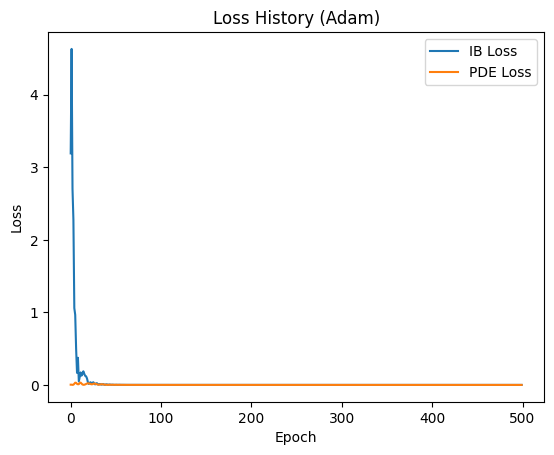

In [ ]:
nn = torch.nn.Sequential(
    torch.nn.Linear(2, 20),
    torch.nn.Tanh(),
    torch.nn.Linear(20, 20),
    torch.nn.Tanh(),
    torch.nn.Linear(20, 20),
    torch.nn.Tanh(),
    torch.nn.Linear(20, 1)
)

# nn = torch.nn.Sequential(
#     torch.nn.Linear(2, 20),
#     torch.nn.ReLU(),
#     torch.nn.Linear(20, 20),
#     torch.nn.ReLU(),
#     torch.nn.Linear(20, 20),
#     torch.nn.ReLU(),
#     torch.nn.Linear(20, 1)
# )

model = EuropeanPINN(nn, K, T, r, sigma, S_inf)

# model.train(S_ib, tau_ib, V_ib, S_pde, tau_pde, S_data, tau_data, V_data, epochs=500, optimizer='lbfgs')
# model.plot_loss(data=False, range=200, save=True, title='Loss History (L-BFGS)', file_name='european_put_loss_lbfgs.pdf')

model.train(S_ib, tau_ib, V_ib, S_pde, tau_pde, S_data, tau_data, V_data, epochs=500, optimizer='adam', lr=1e-1)
model.plot_loss(data=False, range=5000, save=True, title='Loss History (Adam)', file_name='european_put_loss_adam.pdf')

d:\APP_I\Python\Python311\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


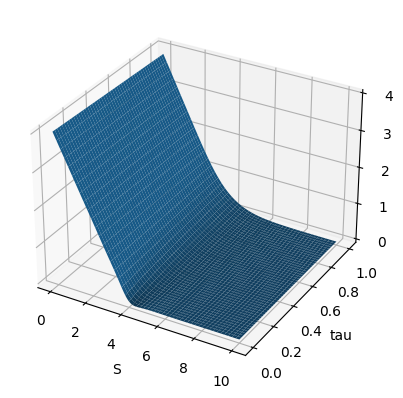

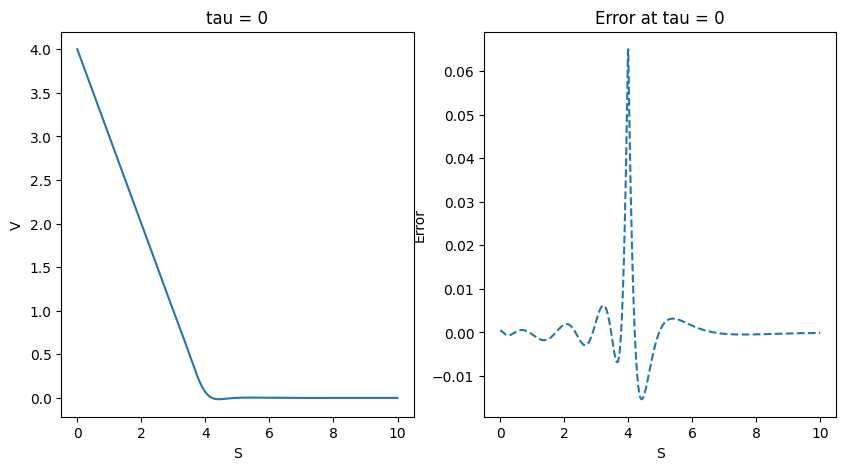

In [10]:
# plot
S_plot = torch.linspace(0, 10, 1000)
tau_plot = torch.linspace(0, T, 1000)
S_plot, tau_plot = torch.meshgrid(S_plot, tau_plot)
V_plot = model(S_plot.reshape(-1, 1), tau_plot.reshape(-1, 1)).detach().reshape(1000, 1000)
# 3d plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S_plot.numpy(), tau_plot.numpy(), V_plot.numpy())
ax.set_xlabel('S')
ax.set_ylabel('tau')
ax.set_zlabel('V')
plt.show()

# plot tau = 0
S_plot = torch.linspace(0, 10, 1000)
V_plot = model(S_plot.reshape(-1, 1), torch.zeros(1000, 1)).reshape(-1).detach()
V_true = torch.max(K - S_plot, torch.zeros_like(S_plot))
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(S_plot, V_plot)
plt.xlabel('S')
plt.ylabel('V')
plt.title('tau = 0')

# plot pointwise error at tau = 0
plt.subplot(122)
plt.plot(S_plot, V_plot - V_true, ls='--')
plt.xlabel('S')
plt.ylabel('Error')
plt.title('Error at tau = 0')
plt.show()

Epoch 100/200:
IB Loss: 3.219728750991635e-05
PDE Loss: 1.3851691619493067e-05
Data Loss: 0.0

Epoch 200/200:
IB Loss: 6.589403255929938e-06
PDE Loss: 6.887346444273135e-06
Data Loss: 0.0



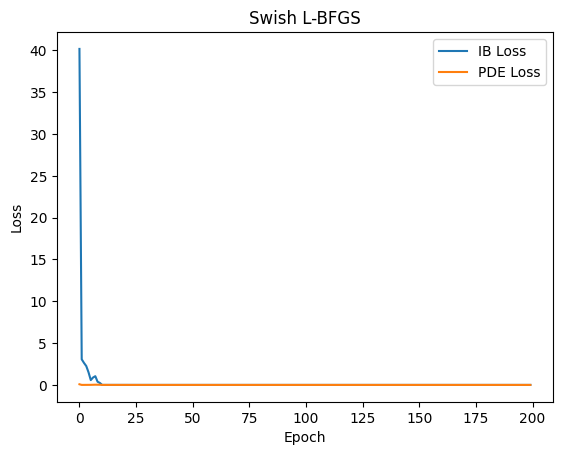

In [20]:
nn = torch.nn.Sequential(
    torch.nn.Linear(2, 20),
    torch.nn.SiLU(),
    torch.nn.Linear(20, 20),
    torch.nn.SiLU(),
    torch.nn.Linear(20, 20),
    torch.nn.SiLU(),
    torch.nn.Linear(20, 1)
)

model = EuropeanPINN(nn, K, T, r, sigma, S_inf)
# First train with Adam for 10 epochs
model.train(S_ib, tau_ib, V_ib, S_pde, tau_pde, S_data, tau_data, V_data, epochs=10, optimizer='adam', lr=1e-1)
# Then train with L-BFGS for 200 epochs
model.train(S_ib, tau_ib, V_ib, S_pde, tau_pde, S_data, tau_data, V_data, epochs=200, optimizer='lbfgs')
model.plot_loss(data=False, range=200, save=True, title='Swish L-BFGS', file_name='european_put_loss_swish_lbfgs.pdf')

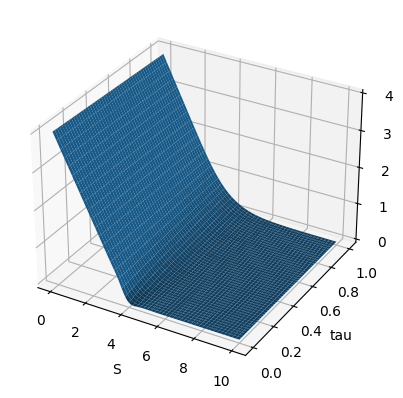

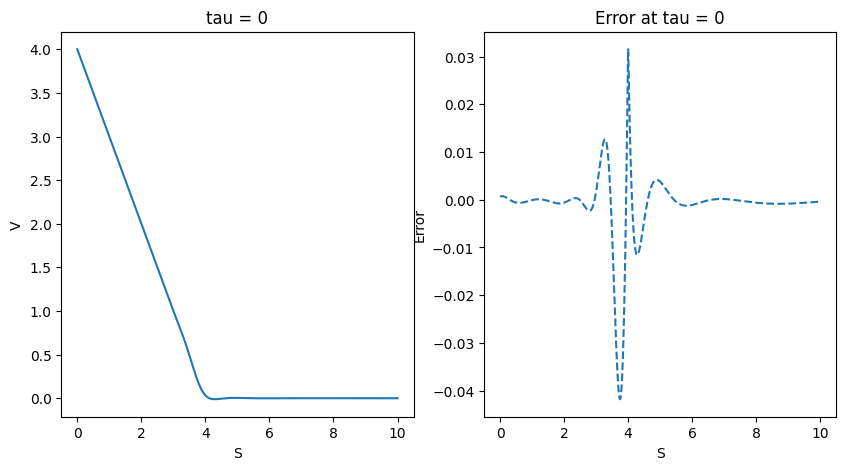

In [21]:
# plot
S_plot = torch.linspace(0, 10, 1000)
tau_plot = torch.linspace(0, T, 1000)
S_plot, tau_plot = torch.meshgrid(S_plot, tau_plot)
V_plot = model(S_plot.reshape(-1, 1), tau_plot.reshape(-1, 1)).detach().reshape(1000, 1000)
# 3d plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S_plot.numpy(), tau_plot.numpy(), V_plot.numpy())
ax.set_xlabel('S')
ax.set_ylabel('tau')
ax.set_zlabel('V')
plt.show()

# plot tau = 0
S_plot = torch.linspace(0, 10, 1000)
V_plot = model(S_plot.reshape(-1, 1), torch.zeros(1000, 1)).reshape(-1).detach()
V_true = torch.max(K - S_plot, torch.zeros_like(S_plot))
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(S_plot, V_plot)
plt.xlabel('S')
plt.ylabel('V')
plt.title('tau = 0')

# plot pointwise error at tau = 0
plt.subplot(122)
plt.plot(S_plot, V_plot - V_true, ls='--')
plt.xlabel('S')
plt.ylabel('Error')
plt.title('Error at tau = 0')
plt.show()